In [ ]:
# filter those with high mean and low variance (for RGB value), identify threshold based on relationship between mean and variance
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
import statsmodels.api as sm
import random
import numpy as np
import scipy as sp
import torchvision
import skimage.io
import skimage.measure
import skimage.color
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#from nuclei_quality_control import *
from utils import *
from extract_features import patchify
from PIL import Image
import numpy as np


## Filter super-pixels with high mean and low variance (for RGB value)

In [3]:
dir = '/edgehpc/dept/compbio/users/aschroed/iSCALE/Data/Gastric/Normal_P1/Scenario1_5Captures/Visium-spot/Run1_1500'
os.chdir(dir)
titlesize = 1

# load in and compute averaged & std rgb value of each tile
he = load_image('he.jpg')
he_tiles, shapes = patchify(he, patch_size=16)
he_mean = [np.mean(he_tile) for he_tile in he_tiles]
he_mean_image = np.reshape(he_mean, shapes['tiles'])
he_std = [np.std(he_tile) for he_tile in he_tiles]
he_std_image = np.reshape(he_std, shapes['tiles'])



Image loaded from he.jpg


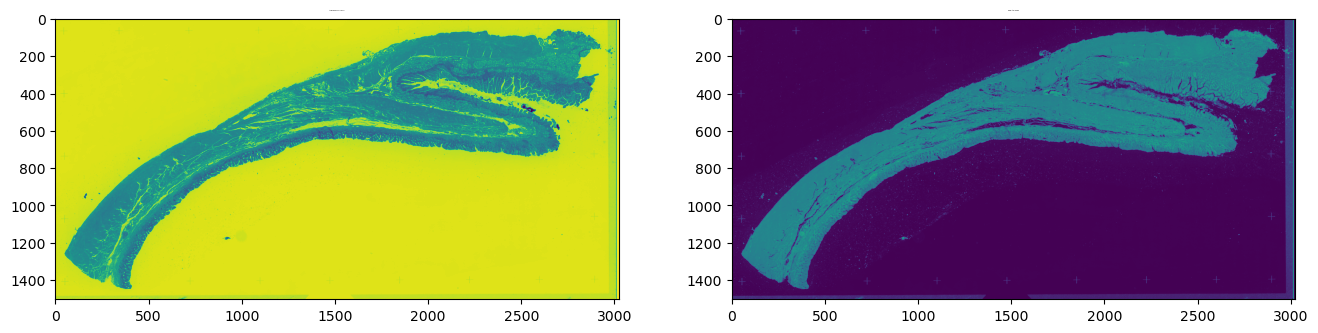

In [4]:
# Display results
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
filtered_he_mean_image = he_mean_image.copy()
#filtered_he_mean_image[~conserve_index_image] = np.nan
plt.imshow(filtered_he_mean_image)
_ = plt.title('Averaged RGB Image', fontsize=titlesize)
plt.subplot(1, 2, 2)
filtered_he_std_image = he_std_image.copy()
#filtered_he_std_image[~conserve_index_image] = np.nan
plt.imshow(filtered_he_std_image)
_ = plt.title('RGB Std Image', fontsize=titlesize)

#plt.savefig('filterRGB/Average_Std_RGB_image.png', dpi=500, bbox_inches='tight')
plt.show()

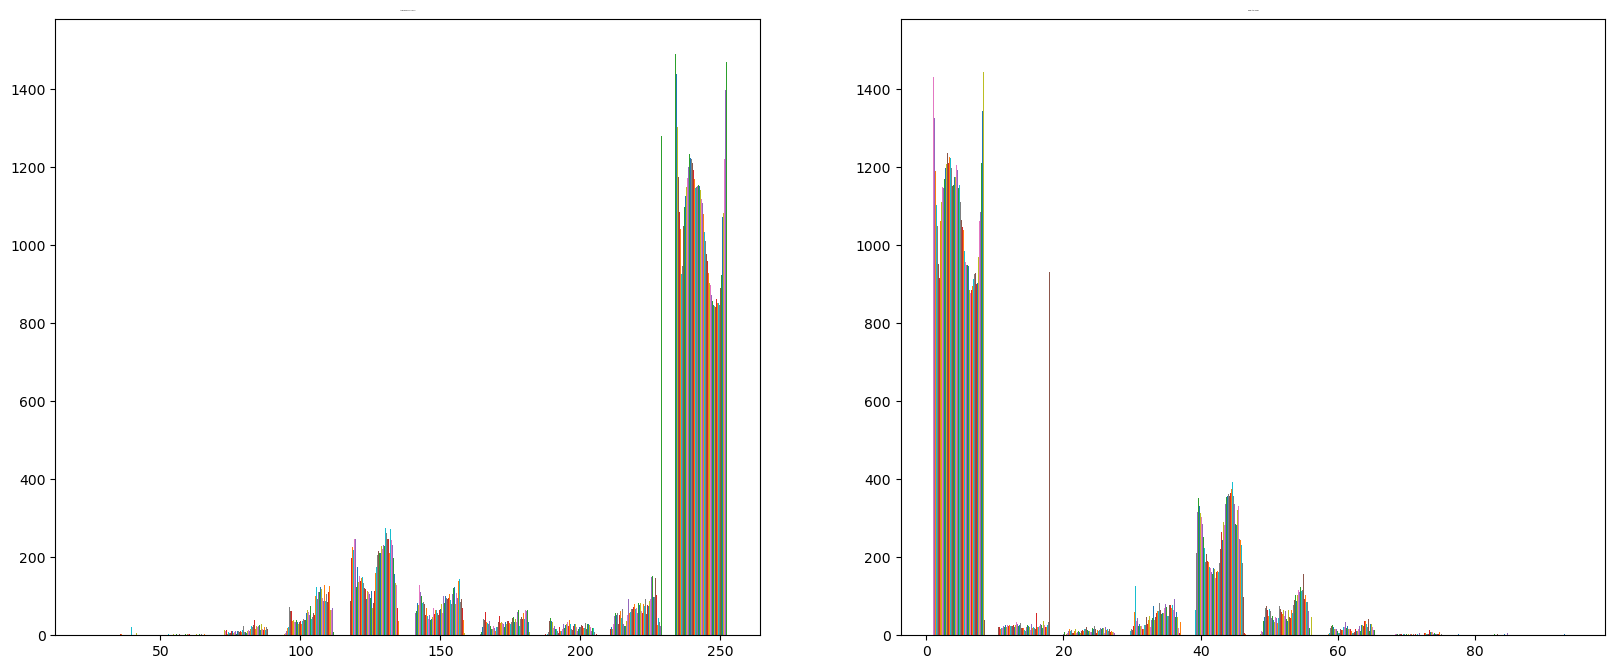

In [5]:
# the histogram of mean and std
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(he_mean_image)
_ = plt.title('Averaged RGB Image', fontsize=titlesize)
plt.subplot(1, 2, 2)
plt.hist(he_std_image)
_ = plt.title('RGB std Image', fontsize=titlesize)

In [6]:
print(np.round(np.percentile(he_mean_image, [25,50,75]),2))
print(np.round(np.percentile(he_std_image, [25,50,75]),2))

[218.69 241.29 243.25]
[ 0.43  1.01 23.58]


## Investigate relationship between mean and variance RGB values

/tmp/ipykernel_2707585/2848965175.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(he_mean_image, he_std_image, s=.2,  cmap='bwr')


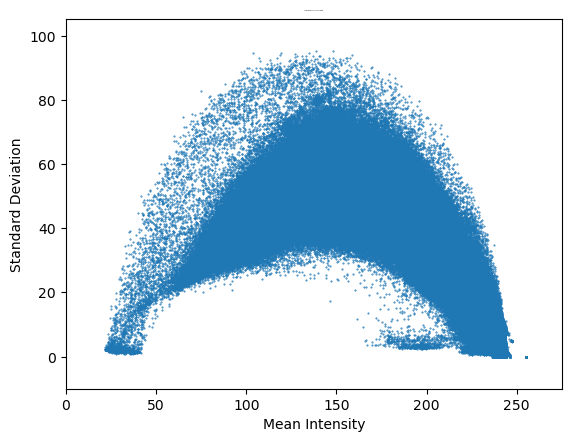

In [7]:
# the scatterplot of mean and std

plt.scatter(he_mean_image, he_std_image, s=.2,  cmap='bwr')
plt.xlim(0, he_mean_image.max()+20)  
plt.ylim(-10, he_std_image.max()+10)  
plt.xlabel('Mean Intensity')
plt.ylabel('Standard Deviation')
_ = plt.title('Averaged RGB vs Std RGB', fontsize=titlesize)

#plt.savefig('filterRGB/scatter_average_vs_std.png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
mean_intensity = he_mean_image.copy().flatten()
std_dev = he_std_image.copy().flatten()

# Step 1: Fit a quadratic model using np.polyfit (mean_intensity, std_dev)
coeffs = np.polyfit(mean_intensity, std_dev, 2)  # Fit a quadratic polynomial 
a, b, c = coeffs  # Coefficients of the quadratic model

# Step 2: Calculate the x-coordinate of the vertex (peak) of the parabola
x_vertex = -b / (2 * a)

# Step 3: Calculate the y-coordinate (standard deviation) at the vertex
y_vertex = a * x_vertex**2 + b * x_vertex + c

# for visualization
def linear_line(x,x_vertex,m):
    return m*x - x_vertex 

print(f"Peak of the parabola occurs at Mean Intensity: {x_vertex:.2f}, Standard Deviation: {y_vertex:.2f}")


In [9]:
# Define the linear boundary that starts at y = 0 and goes through (x_vertex, y_vertex) with slope m
# Input parameter m can be used to adjust the level of filtering

# Define the linear boundary function
def linear_bound(mean_RGB, std_RGB, m):
    coeffs = np.polyfit(mean_RGB, std_RGB, 2)  # Fit quadratic model based on input data
    a, b, c = coeffs
    
    # Calculate the x-coordinate of the vertex (peak)
    x_vertex = -b / (2 * a)
    
    # Calculate the y-intercept for the line with slope m that passes through (x_vertex, 0)
    y_intercept = -m * x_vertex
    
    print(f"Peak of the parabola occurs at Mean Intensity: {x_vertex:.2f}")
    
    return m*mean_RGB - x_vertex 

## Visiualize boundary

In [17]:
m = 1

Peak of the parabola occurs at Mean Intensity: 141.01


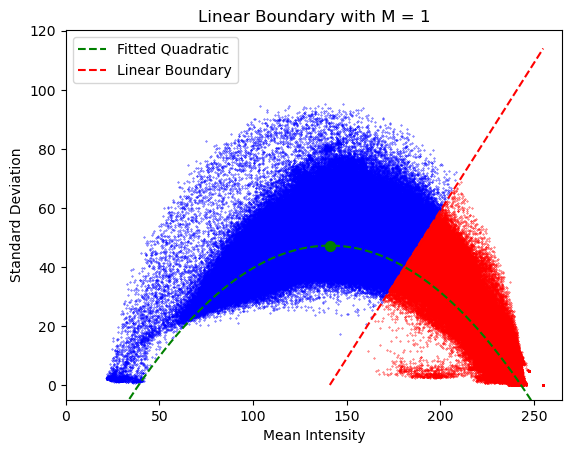

In [18]:
# Calculate the y values of the linear boundary for each mean_intensity
linear_boundary = linear_bound(mean_intensity, std_dev, m)

# Step 1: Create a mask to identify points below the linear boundary
below_boundary_mask = std_dev < linear_boundary

# Step 2: Save the indices of the points below the linear boundary
below_boundary_indices = np.where(below_boundary_mask)[0]

# Step 3: Plot the points, color those below the boundary in red
plt.scatter(mean_intensity[~below_boundary_mask], std_dev[~below_boundary_mask], color='blue', s=.1)
plt.scatter(mean_intensity[below_boundary_mask], std_dev[below_boundary_mask], color='red', s=.1)

# Plot the quadratic curve for visualization
x_vals = np.linspace(np.min(mean_intensity), np.max(mean_intensity), 500)
y_vals = a * x_vals**2 + b * x_vals + c
plt.plot(x_vals, y_vals, 'g--', label='Fitted Quadratic')

# Mark the vertex (peak)
plt.scatter([x_vertex], [y_vertex], color='green', s=50, zorder=5)

# Plot the linear boundary line
x_line = np.linspace(x_vertex, np.max(mean_intensity), 500)
y_line = linear_line(x_line, x_vertex, m)
plt.plot(x_line, y_line, 'r--', label='Linear Boundary')
plt.xlim(0, he_mean_image.max()+10)  
plt.ylim(-5, he_std_image.max()+25)  

# Plot settings
plt.xlabel('Mean Intensity')
plt.ylabel('Standard Deviation')
plt.title(f'Linear Boundary with M = {m}')
plt.legend()
plt.show()


## Establish which pixels should be filtered using the linear boundary between STD and mean RGB

In [19]:
# Calculate the linear boundary for each mean intensity value
# i.e. For each mean intensity value, we identify the corressponding std cut-off 
linear_boundary = linear_bound(mean_intensity, std_dev, m)

# Superpixels where he_std is below the boundary will be marked as to remove
conserve_index = [True if he_std[i] >= linear_boundary[i] else False for i in range(len(he_tiles))]
save_pickle(conserve_index, f'filterRGB/conserve_index_linearBoundary_m{m}.pickle')
conserve_index_image = np.reshape(conserve_index, shapes['tiles'])

Peak of the parabola occurs at Mean Intensity: 141.01
filterRGB/conserve_index_linearBoundary_m1.pickle


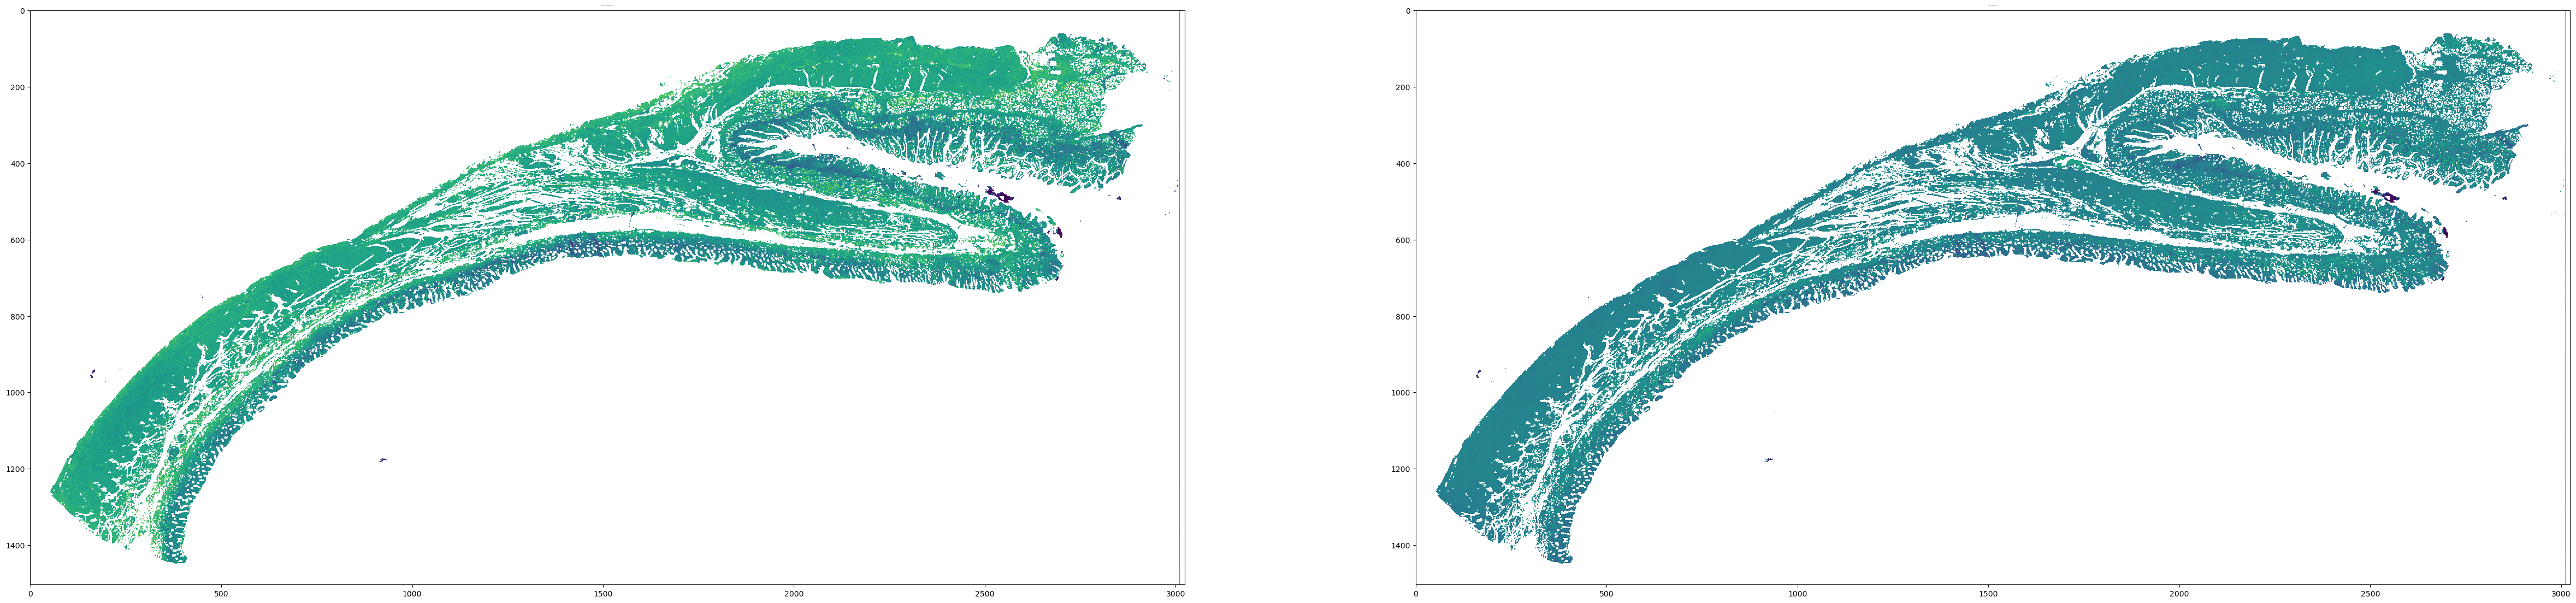

In [20]:
# Display results
plt.figure(figsize=(60, 50))
plt.subplot(1, 2, 1)
filtered_he_mean_image = he_mean_image.copy()
filtered_he_mean_image[~conserve_index_image] = np.nan
plt.imshow(filtered_he_mean_image)
_ = plt.title('Filtered Averaged RGB Image', fontsize=titlesize)
plt.subplot(1, 2, 2)
filtered_he_std_image = he_std_image.copy()
filtered_he_std_image[~conserve_index_image] = np.nan
plt.imshow(filtered_he_std_image)
_ = plt.title('Filtered RGB std Image', fontsize=titlesize)

plt.savefig(f'filterRGB/Filtered_LinearBoundary_m{m}_RGB_image.png', dpi=500, bbox_inches='tight')
plt.show()

# Create tissue mask

In [21]:
import numpy as np
from PIL import Image

# Define the image dimensions and super-pixel size
image_height, image_width = he.shape[0], he.shape[1]
super_pixel_size = 16

# Create a numpy array to hold the mask, initially all zeros
mask = np.zeros((image_height, image_width), dtype=np.uint8)

# Reshape the True/False list to match the super-pixel grid layout
num_super_pixels_y = image_height // super_pixel_size
num_super_pixels_x = image_width // super_pixel_size

# Convert the True/False list into a 2D array corresponding to the super-pixel grid
super_pixel_values = np.array(conserve_index).reshape((num_super_pixels_y, num_super_pixels_x))

# Populate the mask based on the values of the super-pixel grid
for i in range(num_super_pixels_y):
    for j in range(num_super_pixels_x):
        value = 255 if super_pixel_values[i, j] else 0  # Use 255 for white, 0 for black
        # Set the corresponding region in the mask
        mask[i * super_pixel_size:(i + 1) * super_pixel_size, j * super_pixel_size:(j + 1) * super_pixel_size] = value



In [22]:
# Convert the mask to a PIL image
mask_image = Image.fromarray(mask)

# Save the mask as an image file
mask_image.save(f'filterRGB/mask_filtered_linearBoundary_m{m}.png')



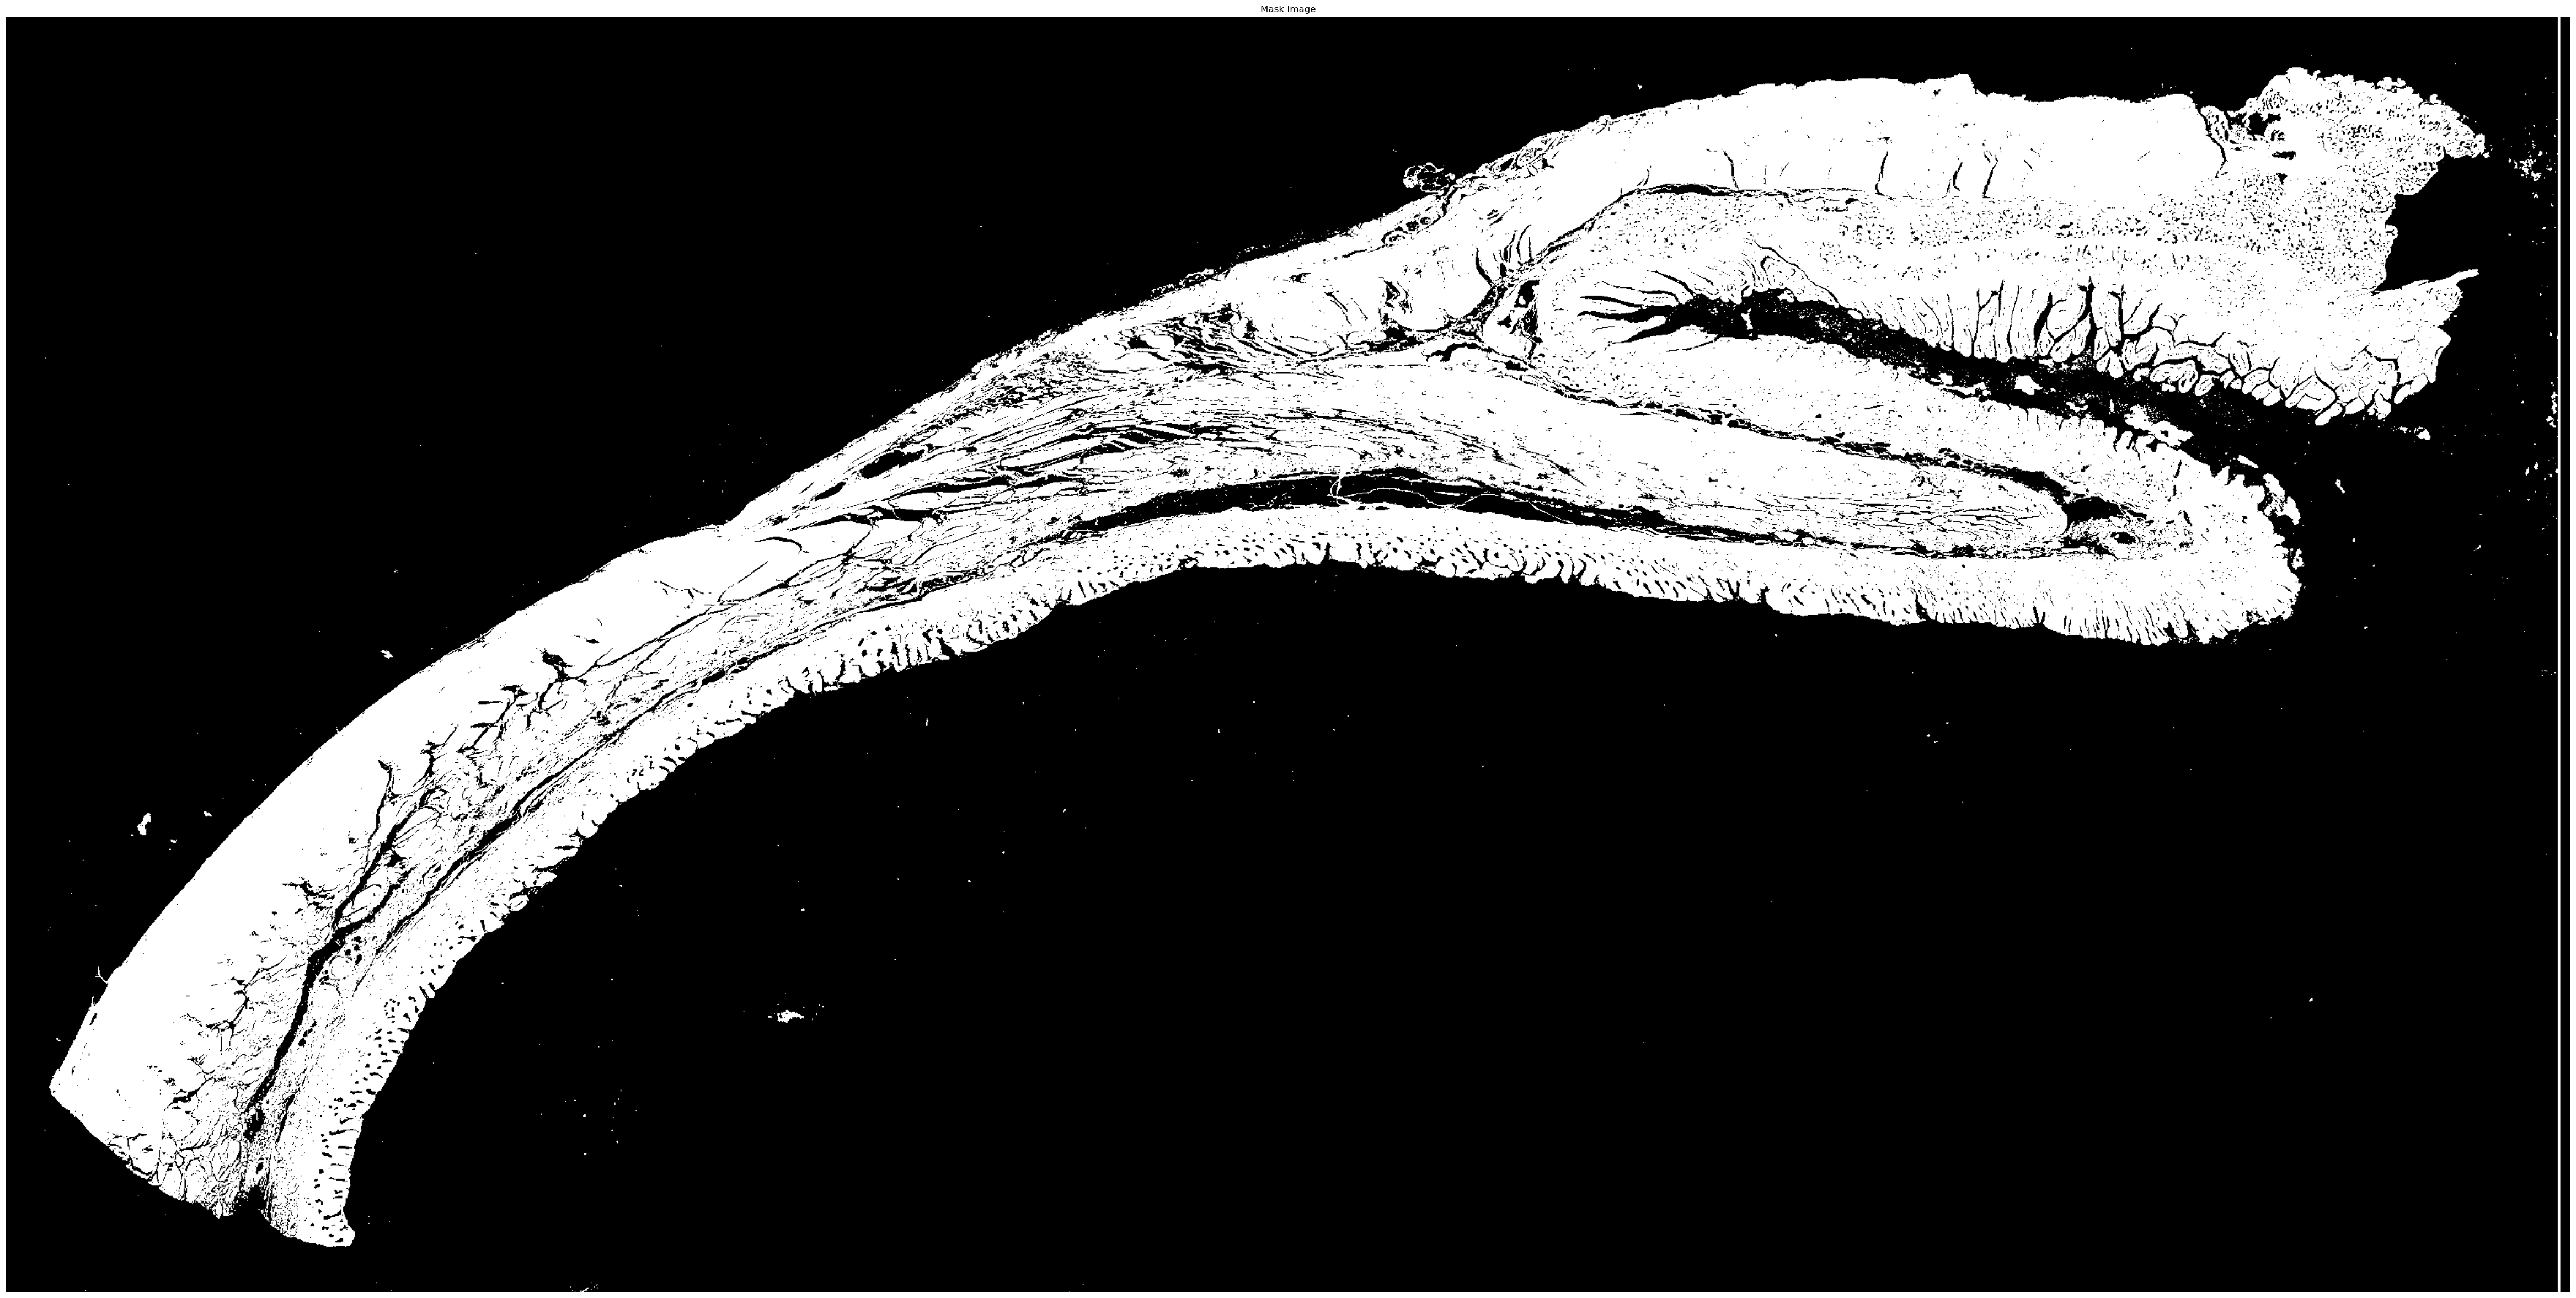

In [23]:
# Plot the mask
plt.figure(figsize=(60, 50))

plt.imshow(mask, cmap='gray')  # Use 'gray' colormap for a binary mask
plt.title('Mask Image')
plt.axis('off') 
plt.show()


In [ ]:
os.chdir(dir)

# Step 1: Load the mask images
mask1 = Image.open(f"filterRGB/mask_filtered_linearBoundary_m{m}.png").convert("L")  # Convert to grayscale
mask2 = Image.open("mask.jpg").convert("L")  # Convert to grayscale

# Step 2: Convert to numpy arrays
mask1_array = np.array(mask1)
mask2_array = np.array(mask2)

# Step 3: Combine the masks
# If a pixel is black (value=0) in either mask, it should be black (0)
combined_mask_array = np.where((mask1_array == 0) | (mask2_array == 0), 0, 255).astype(np.uint8)

# Step 4: Convert the combined mask back to an image
combined_mask = Image.fromarray(combined_mask_array)

# Step 5: Save the combined mask
combined_mask.save("filterRGB/mask-refined.png")
